<a href="https://colab.research.google.com/github/chipzm/NUIG_Thesis/blob/main/COCO_JSON_to_YOLO_TXT_and_Counting_Beluga_Whale_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import os
import shutil
import json
import random
import numpy as np
import tqdm

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !curl https://sdk.cloud.google.com | bash

In [ ]:
!gsutil -m cp -r gs://public-datasets-lila/wild-me/beluga.coco.tar.gz .

Copying gs://public-datasets-lila/wild-me/beluga.coco.tar.gz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1/1 files][563.0 MiB/563.0 MiB] 100% Done                                    
Operation completed over 1 objects/563.0 MiB.                                    


In [ ]:
# to remove a directory and its sub directories
import shutil
# Replace with the path to the directory you want to remove
directory = '/content/tmp'
shutil.rmtree(directory)

In [ ]:
# Extract tar.gz files
!tar -xzvf "/content/beluga.coco.tar.gz" -C "/content/"

In [ ]:
from pycocotools.coco import COCO
data_source = COCO(annotation_file='/content/beluga.coco/annotations/instances_train2022.json')

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [ ]:
img_ids = data_source.getImgIds()
catIds = data_source.getCatIds()

categories = data_source.loadCats(catIds)
categories.sort(key=lambda x: x['id'])

classes = {}
coco_labels = {}
coco_labels_inverse = {}

for c in categories:
    coco_labels[len(classes)] = c['id']
    coco_labels_inverse[c['id']] = len(classes)
    classes[c['name']] = len(classes)

class_num = {}

In [ ]:
classes, coco_labels, coco_labels_inverse, class_num

({'beluga_whale': 0}, {0: 0}, {0: 0}, {})

In [ ]:
!mkdir -p tmp/labels tmp/images
save_base_path  = 'tmp/labels/'
save_image_path = 'tmp/images/'

In [ ]:
# remapping label id to 0~1
label_transfer = {0: 0}

In [ ]:
img_ids

In [ ]:
for index, img_id in tqdm.tqdm(enumerate(img_ids), desc='change .json file to .txt file'):
    img_info = data_source.loadImgs(img_id)[0]

    # Change the path containing the folder to the file name
    save_name = img_info['file_name'].replace('/', '_')

    # Removing file extensions
    file_name = save_name.split('.')[0]

    # Get the width and height of each image
    height = img_info['height']
    width = img_info['width']

    # Save the converted txt file into tmp folder created
    save_path = save_base_path + file_name + '.txt'
    is_exist = False # To check whether the file already exists

    with open(save_path, mode='w') as fp:
      annotation_id = data_source.getAnnIds(img_id)
      boxes = np.zeros((0, 5))
      if len(annotation_id) == 0: # if there are no annotations for that image or no classes in the image
            fp.write('')
            continue

      annotations = data_source.loadAnns(annotation_id)
      lines = ''

      for annotation in annotations:
        # to get the label of the object
        label = coco_labels_inverse[annotation['category_id']]

        if label in label_transfer.keys():
          is_exist = True
          box = annotation['bbox']
          if box[2] < 1 or box[3] < 1:
            continue
          box[0] = round((box[0] + box[2] / 2) / width, 6)
          box[1] = round((box[1] + box[3] / 2) / height, 6)
          box[2] = round(box[2] / width, 6)
          box[3] = round(box[3] / height, 6)

          if label not in class_num.keys():
            class_num[label] = 0

          class_num[label] += 1
          lines = lines + str(label)

          for i in box:
            lines += ' ' + str(i)
          lines += '\n'

      fp.writelines(lines)

    if is_exist:
        # if there is a target type directory, copy it
      shutil.copy('/content/beluga.coco/images/train2022/{}'.format(img_info['file_name']), os.path.join(save_image_path, save_name))
    else:
      os.remove(save_path)

change .json file to .txt file: 5902it [00:06, 875.84it/s]


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('tmp', output="beluga", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 11804 files [00:03, 3055.30 files/s]


In [ ]:
!pip install super-gradients

  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
from PIL import Image
import os
import numpy as np
import torch

import random
import pathlib
import requests

from torch.utils.data import Dataset
import json
from torchvision import transforms, utils

from pathlib import Path
import cv2
import matplotlib.pyplot as plt

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

[2023-08-13 09:28:55] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-08-13 09:29:05] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-08-13 09:29:09] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-08-13 09:29:09] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-08-13 09:29:09] WARNING - export.py - Failed to import pytorch_quantization
[2023-08-13 09:29:09] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
class config:
  #trainer params
  exp_name = 'beluga_detection'
  chkpt = 'chkpt'

  #dataset params
  data_dir = '/content/beluga'

  train_images = 'train/images'
  train_labels = 'train/labels'

  val_images = 'val/images'
  val_labels = 'val/labels'

  test_images = 'test/images'
  test_labels = 'test/labels'

  classes = ['beluga_whale']
  num_classes = len(classes)

  #dataloader params - you can add whatever PyTorch dataloader params you have could be different across train, val, and test
  dataloader_params = {'batch_size':8, 'num_workers':2}

  #model params
  model_name = 'yolo_nas_l'
  pretrained_weights = 'coco'

In [ ]:
# trainer
trainer = Trainer(experiment_name = config.exp_name, ckpt_root_dir = config.chkpt)

In [ ]:
# dataloaders and datasets
train_data = coco_detection_yolo_format_train(dataset_params = {'data_dir': config.data_dir,
                                'images_dir': config.train_images,
                                'labels_dir': config.train_labels,
                                'classes': config.classes},
              dataloader_params = config.dataloader_params)

val_data = coco_detection_yolo_format_val(dataset_params = {'data_dir': config.data_dir,
                                'images_dir': config.val_images,
                                'labels_dir': config.val_labels,
                                'classes': config.classes},
              dataloader_params = config.dataloader_params)

test_data = coco_detection_yolo_format_val(dataset_params = {'data_dir': config.data_dir,
                                'images_dir': config.test_images,
                                'labels_dir': config.test_labels,
                                'classes': config.classes},
              dataloader_params = config.dataloader_params)

Caching annotations: 100%|██████████| 591/591 [00:00<00:00, 7231.18it/s]


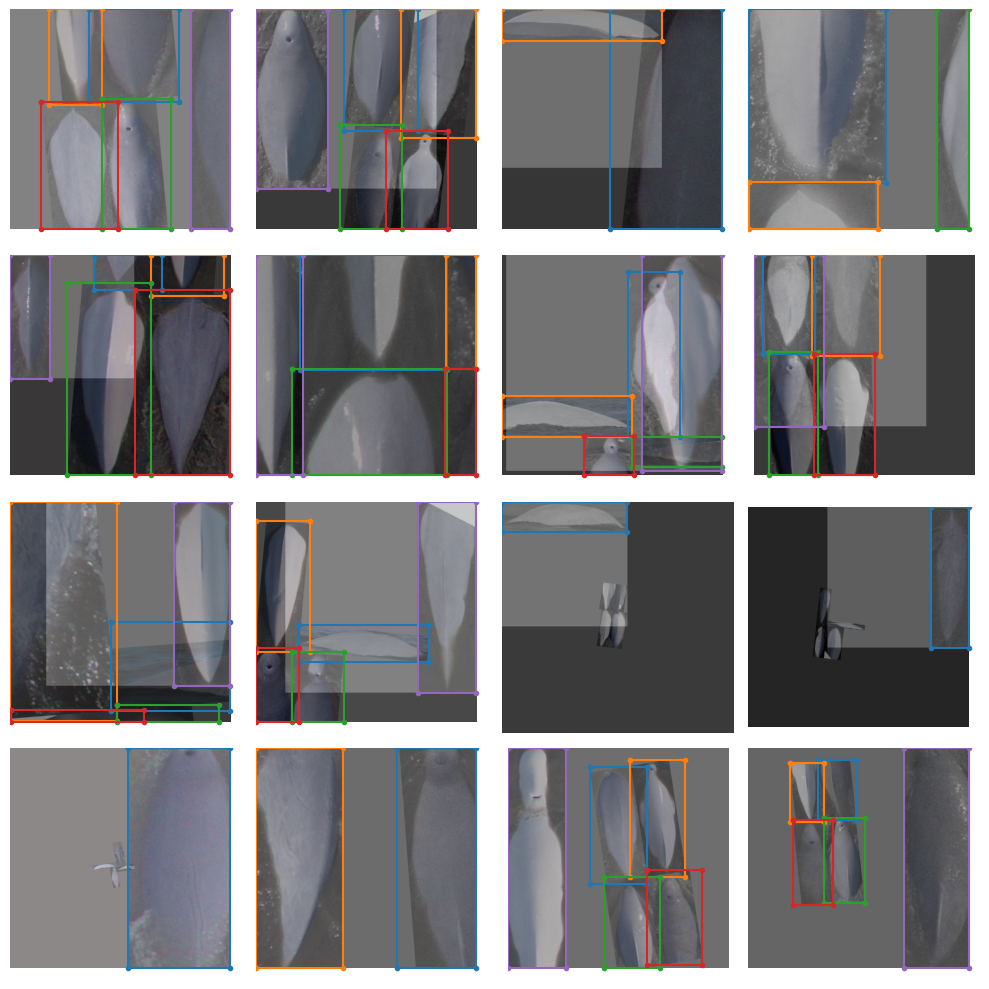

In [ ]:
# plotting the images
train_data.dataset.plot()

In [ ]:
# Instantiating the model
model = models.get(config.model_name,
                   num_classes=config.num_classes,
                   pretrained_weights=config.pretrained_weights)

[2023-08-13 09:31:49] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:03<00:00, 70.5MB/s]


In [ ]:
# Defining training metrics and parameters
train_params = {# ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "lr_warmup_epochs": 5,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 25,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.num_classes,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.num_classes,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
# Training the model
trainer.train(model = model,
              training_params = train_params,
              train_loader = train_data,
              valid_loader = val_data)

The console stream is now moved to chkpt/beluga_detection/console_Aug13_09_35_00.txt


[2023-08-13 09:35:01] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-13 09:35:04] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 4721       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         590        (len(train_loader))
    - Gradient updates per epoch:   590        (len(train_loader) / batch_accumulate)

[2023-08-13 09:35:04] INFO - sg_trainer.py - Started training for 25 epochs (0/24)

Validating: 100%|██████████| 73/73 [00:16<00:00,  4.38it/s]
[2023-08-13 09:43:30] INFO - base_sg_logger.py 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7493
│   ├── Ppyoloeloss/loss_iou = 0.0771
│   ├── Ppyoloeloss/loss_dfl = 0.8589
│   └── Ppyoloeloss/loss = 1.3717
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3711
    ├── Ppyoloeloss/loss_iou = 0.0073
    ├── Ppyoloeloss/loss_dfl = 0.6478
    ├── Ppyoloeloss/loss = 0.7133
    ├── Precision@0.50 = 0.2203
    ├── Recall@0.50 = 1.0
    ├── Map@0.50 = 1.0
    └── F1@0.50 = 0.3611



Validating epoch 1: 100%|██████████| 73/73 [00:14<00:00,  5.17it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5572
│   │   ├── Epoch N-1      = 0.7493 (↘ -0.1921)
│   │   └── Best until now = 0.7493 (↘ -0.1921)
│   ├── Ppyoloeloss/loss_iou = 0.0626
│   │   ├── Epoch N-1      = 0.0771 (↘ -0.0146)
│   │   └── Best until now = 0.0771 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.7655
│   │   ├── Epoch N-1      = 0.8589 (↘ -0.0934)
│   │   └── Best until now = 0.8589 (↘ -0.0934)
│   └── Ppyoloeloss/loss = 1.0964
│       ├── Epoch N-1      = 1.3717 (↘ -0.2752)
│       └── Best until now = 1.3717 (↘ -0.2752)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3697
    │   ├── Epoch N-1      = 0.3711 (↘ -0.0014)
    │   └── Best until now = 0.3711 (↘ -0.0014)
    ├── Ppyoloeloss/loss_iou = 0.0116
    │   ├── Epoch N-1      = 0.0073 (↗ 0.0043)
    │   └── Best until now = 0.0073 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.6522
    │   ├── Epoch N-1      = 0.6478 (↗ 0.0044)
    │   └── Best until now = 0.6478 (↗ 0.0044)
    ├── Ppyoloeloss/loss =

Validating epoch 2: 100%|██████████| 73/73 [00:13<00:00,  5.38it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5556
│   │   ├── Epoch N-1      = 0.5572 (↘ -0.0015)
│   │   └── Best until now = 0.5572 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.0657
│   │   ├── Epoch N-1      = 0.0626 (↗ 0.0031)
│   │   └── Best until now = 0.0626 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.7742
│   │   ├── Epoch N-1      = 0.7655 (↗ 0.0087)
│   │   └── Best until now = 0.7655 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 1.1071
│       ├── Epoch N-1      = 1.0964 (↗ 0.0106)
│       └── Best until now = 1.0964 (↗ 0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4285
    │   ├── Epoch N-1      = 0.3697 (↗ 0.0588)
    │   └── Best until now = 0.3697 (↗ 0.0588)
    ├── Ppyoloeloss/loss_iou = 0.0118
    │   ├── Epoch N-1      = 0.0116 (↗ 0.0002)
    │   └── Best until now = 0.0073 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.6524
    │   ├── Epoch N-1      = 0.6522 (↗ 1e-04)
    │   └── Best until now = 0.6478 (↗ 0.0046)
    ├── Ppyoloeloss/loss = 0.7842
 

Validating epoch 3: 100%|██████████| 73/73 [00:13<00:00,  5.24it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5519
│   │   ├── Epoch N-1      = 0.5556 (↘ -0.0037)
│   │   └── Best until now = 0.5556 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.0667
│   │   ├── Epoch N-1      = 0.0657 (↗ 0.001)
│   │   └── Best until now = 0.0626 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.7733
│   │   ├── Epoch N-1      = 0.7742 (↘ -0.0009)
│   │   └── Best until now = 0.7655 (↗ 0.0078)
│   └── Ppyoloeloss/loss = 1.1053
│       ├── Epoch N-1      = 1.1071 (↘ -0.0018)
│       └── Best until now = 1.0964 (↗ 0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4382
    │   ├── Epoch N-1      = 0.4285 (↗ 0.0097)
    │   └── Best until now = 0.3697 (↗ 0.0685)
    ├── Ppyoloeloss/loss_iou = 0.0144
    │   ├── Epoch N-1      = 0.0118 (↗ 0.0026)
    │   └── Best until now = 0.0073 (↗ 0.0071)
    ├── Ppyoloeloss/loss_dfl = 0.6586
    │   ├── Epoch N-1      = 0.6524 (↗ 0.0062)
    │   └── Best until now = 0.6478 (↗ 0.0108)
    ├── Ppyoloeloss/loss = 0.8035

Validating epoch 4: 100%|██████████| 73/73 [00:13<00:00,  5.25it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5555
│   │   ├── Epoch N-1      = 0.5519 (↗ 0.0037)
│   │   └── Best until now = 0.5519 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.0688
│   │   ├── Epoch N-1      = 0.0667 (↗ 0.0021)
│   │   └── Best until now = 0.0626 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.7774
│   │   ├── Epoch N-1      = 0.7733 (↗ 0.0042)
│   │   └── Best until now = 0.7655 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 1.1162
│       ├── Epoch N-1      = 1.1053 (↗ 0.0109)
│       └── Best until now = 1.0964 (↗ 0.0198)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4916
    │   ├── Epoch N-1      = 0.4382 (↗ 0.0534)
    │   └── Best until now = 0.3697 (↗ 0.1219)
    ├── Ppyoloeloss/loss_iou = 0.0129
    │   ├── Epoch N-1      = 0.0144 (↘ -0.0015)
    │   └── Best until now = 0.0073 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.6543
    │   ├── Epoch N-1      = 0.6586 (↘ -0.0043)
    │   └── Best until now = 0.6478 (↗ 0.0065)
    ├── Ppyoloeloss/loss = 0.851
 

Validating epoch 5: 100%|██████████| 73/73 [00:14<00:00,  5.10it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5536
│   │   ├── Epoch N-1      = 0.5555 (↘ -0.002)
│   │   └── Best until now = 0.5519 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.0689
│   │   ├── Epoch N-1      = 0.0688 (↗ 1e-04)
│   │   └── Best until now = 0.0626 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.776
│   │   ├── Epoch N-1      = 0.7774 (↘ -0.0014)
│   │   └── Best until now = 0.7655 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 1.1139
│       ├── Epoch N-1      = 1.1162 (↘ -0.0024)
│       └── Best until now = 1.0964 (↗ 0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3988
    │   ├── Epoch N-1      = 0.4916 (↘ -0.0928)
    │   └── Best until now = 0.3697 (↗ 0.0291)
    ├── Ppyoloeloss/loss_iou = 0.0168
    │   ├── Epoch N-1      = 0.0129 (↗ 0.0039)
    │   └── Best until now = 0.0073 (↗ 0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.6579
    │   ├── Epoch N-1      = 0.6543 (↗ 0.0036)
    │   └── Best until now = 0.6478 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 0.7697
 

Validating epoch 6: 100%|██████████| 73/73 [00:14<00:00,  5.13it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5356
│   │   ├── Epoch N-1      = 0.5536 (↘ -0.0179)
│   │   └── Best until now = 0.5519 (↘ -0.0162)
│   ├── Ppyoloeloss/loss_iou = 0.0648
│   │   ├── Epoch N-1      = 0.0689 (↘ -0.0041)
│   │   └── Best until now = 0.0626 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.7619
│   │   ├── Epoch N-1      = 0.776  (↘ -0.0141)
│   │   └── Best until now = 0.7655 (↘ -0.0036)
│   └── Ppyoloeloss/loss = 1.0786
│       ├── Epoch N-1      = 1.1139 (↘ -0.0353)
│       └── Best until now = 1.0964 (↘ -0.0179)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7467
    │   ├── Epoch N-1      = 0.3988 (↗ 0.3479)
    │   └── Best until now = 0.3697 (↗ 0.377)
    ├── Ppyoloeloss/loss_iou = 0.0165
    │   ├── Epoch N-1      = 0.0168 (↘ -0.0003)
    │   └── Best until now = 0.0073 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.6602
    │   ├── Epoch N-1      = 0.6579 (↗ 0.0024)
    │   └── Best until now = 0.6478 (↗ 0.0124)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 7: 100%|██████████| 73/73 [00:14<00:00,  5.01it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5238
│   │   ├── Epoch N-1      = 0.5356 (↘ -0.0119)
│   │   └── Best until now = 0.5356 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.0626
│   │   ├── Epoch N-1      = 0.0648 (↘ -0.0022)
│   │   └── Best until now = 0.0626 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.7531
│   │   ├── Epoch N-1      = 0.7619 (↘ -0.0088)
│   │   └── Best until now = 0.7619 (↘ -0.0088)
│   └── Ppyoloeloss/loss = 1.0569
│       ├── Epoch N-1      = 1.0786 (↘ -0.0217)
│       └── Best until now = 1.0786 (↘ -0.0217)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4014
    │   ├── Epoch N-1      = 0.7467 (↘ -0.3453)
    │   └── Best until now = 0.3697 (↗ 0.0317)
    ├── Ppyoloeloss/loss_iou = 0.0154
    │   ├── Epoch N-1      = 0.0165 (↘ -0.0011)
    │   └── Best until now = 0.0073 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.6579
    │   ├── Epoch N-1      = 0.6602 (↘ -0.0023)
    │   └── Best until now = 0.6478 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 0.

Validating epoch 8: 100%|██████████| 73/73 [00:15<00:00,  4.83it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5118
│   │   ├── Epoch N-1      = 0.5238 (↘ -0.012)
│   │   └── Best until now = 0.5238 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.0581
│   │   ├── Epoch N-1      = 0.0626 (↘ -0.0045)
│   │   └── Best until now = 0.0626 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.7362
│   │   ├── Epoch N-1      = 0.7531 (↘ -0.0169)
│   │   └── Best until now = 0.7531 (↘ -0.0169)
│   └── Ppyoloeloss/loss = 1.0251
│       ├── Epoch N-1      = 1.0569 (↘ -0.0318)
│       └── Best until now = 1.0569 (↘ -0.0318)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.479
    │   ├── Epoch N-1      = 0.4014 (↗ 0.0775)
    │   └── Best until now = 0.3697 (↗ 0.1093)
    ├── Ppyoloeloss/loss_iou = 0.0193
    │   ├── Epoch N-1      = 0.0154 (↗ 0.0039)
    │   └── Best until now = 0.0073 (↗ 0.012)
    ├── Ppyoloeloss/loss_dfl = 0.6673
    │   ├── Epoch N-1      = 0.6579 (↗ 0.0093)
    │   └── Best until now = 0.6478 (↗ 0.0195)
    ├── Ppyoloeloss/loss = 0.860

Validating epoch 9: 100%|██████████| 73/73 [00:14<00:00,  5.04it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5061
│   │   ├── Epoch N-1      = 0.5118 (↘ -0.0057)
│   │   └── Best until now = 0.5118 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.0561
│   │   ├── Epoch N-1      = 0.0581 (↘ -0.002)
│   │   └── Best until now = 0.0581 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.7302
│   │   ├── Epoch N-1      = 0.7362 (↘ -0.006)
│   │   └── Best until now = 0.7362 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.0114
│       ├── Epoch N-1      = 1.0251 (↘ -0.0137)
│       └── Best until now = 1.0251 (↘ -0.0137)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3623
    │   ├── Epoch N-1      = 0.479  (↘ -0.1166)
    │   └── Best until now = 0.3697 (↘ -0.0074)
    ├── Ppyoloeloss/loss_iou = 0.0115
    │   ├── Epoch N-1      = 0.0193 (↘ -0.0078)
    │   └── Best until now = 0.0073 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 0.6492
    │   ├── Epoch N-1      = 0.6673 (↘ -0.018)
    │   └── Best until now = 0.6478 (↗ 0.0014)
    ├── Ppyoloeloss/loss = 0.

Validating epoch 10: 100%|██████████| 73/73 [00:14<00:00,  5.16it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4897
│   │   ├── Epoch N-1      = 0.5061 (↘ -0.0164)
│   │   └── Best until now = 0.5061 (↘ -0.0164)
│   ├── Ppyoloeloss/loss_iou = 0.054
│   │   ├── Epoch N-1      = 0.0561 (↘ -0.0021)
│   │   └── Best until now = 0.0561 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7224
│   │   ├── Epoch N-1      = 0.7302 (↘ -0.0077)
│   │   └── Best until now = 0.7302 (↘ -0.0077)
│   └── Ppyoloeloss/loss = 0.9859
│       ├── Epoch N-1      = 1.0114 (↘ -0.0255)
│       └── Best until now = 1.0114 (↘ -0.0255)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3563
    │   ├── Epoch N-1      = 0.3623 (↘ -0.006)
    │   └── Best until now = 0.3623 (↘ -0.006)
    ├── Ppyoloeloss/loss_iou = 0.0109
    │   ├── Epoch N-1      = 0.0115 (↘ -0.0006)
    │   └── Best until now = 0.0073 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.6516
    │   ├── Epoch N-1      = 0.6492 (↗ 0.0024)
    │   └── Best until now = 0.6478 (↗ 0.0038)
    ├── Ppyoloeloss/loss = 

Validating epoch 11: 100%|██████████| 73/73 [00:13<00:00,  5.31it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4745
│   │   ├── Epoch N-1      = 0.4897 (↘ -0.0152)
│   │   └── Best until now = 0.4897 (↘ -0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.0507
│   │   ├── Epoch N-1      = 0.054  (↘ -0.0033)
│   │   └── Best until now = 0.054  (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.7102
│   │   ├── Epoch N-1      = 0.7224 (↘ -0.0122)
│   │   └── Best until now = 0.7224 (↘ -0.0122)
│   └── Ppyoloeloss/loss = 0.9563
│       ├── Epoch N-1      = 0.9859 (↘ -0.0295)
│       └── Best until now = 0.9859 (↘ -0.0295)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5173
    │   ├── Epoch N-1      = 0.3563 (↗ 0.1609)
    │   └── Best until now = 0.3563 (↗ 0.1609)
    ├── Ppyoloeloss/loss_iou = 0.0124
    │   ├── Epoch N-1      = 0.0109 (↗ 0.0015)
    │   └── Best until now = 0.0073 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.6548
    │   ├── Epoch N-1      = 0.6516 (↗ 0.0032)
    │   └── Best until now = 0.6478 (↗ 0.007)
    ├── Ppyoloeloss/loss = 0

Validating epoch 12: 100%|██████████| 73/73 [00:13<00:00,  5.28it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.463
│   │   ├── Epoch N-1      = 0.4745 (↘ -0.0116)
│   │   └── Best until now = 0.4745 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.0484
│   │   ├── Epoch N-1      = 0.0507 (↘ -0.0023)
│   │   └── Best until now = 0.0507 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.7016
│   │   ├── Epoch N-1      = 0.7102 (↘ -0.0087)
│   │   └── Best until now = 0.7102 (↘ -0.0087)
│   └── Ppyoloeloss/loss = 0.9347
│       ├── Epoch N-1      = 0.9563 (↘ -0.0217)
│       └── Best until now = 0.9563 (↘ -0.0217)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4972
    │   ├── Epoch N-1      = 0.5173 (↘ -0.0201)
    │   └── Best until now = 0.3563 (↗ 0.1408)
    ├── Ppyoloeloss/loss_iou = 0.0118
    │   ├── Epoch N-1      = 0.0124 (↘ -0.0006)
    │   └── Best until now = 0.0073 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.656
    │   ├── Epoch N-1      = 0.6548 (↗ 0.0012)
    │   └── Best until now = 0.6478 (↗ 0.0082)
    ├── Ppyoloeloss/loss = 

Validating epoch 13: 100%|██████████| 73/73 [00:13<00:00,  5.51it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4657
│   │   ├── Epoch N-1      = 0.463  (↗ 0.0028)
│   │   └── Best until now = 0.463  (↗ 0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.0484
│   │   ├── Epoch N-1      = 0.0484 (↗ 0.0)
│   │   └── Best until now = 0.0484 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.7028
│   │   ├── Epoch N-1      = 0.7016 (↗ 0.0013)
│   │   └── Best until now = 0.7016 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 0.9381
│       ├── Epoch N-1      = 0.9347 (↗ 0.0034)
│       └── Best until now = 0.9347 (↗ 0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3795
    │   ├── Epoch N-1      = 0.4972 (↘ -0.1177)
    │   └── Best until now = 0.3563 (↗ 0.0231)
    ├── Ppyoloeloss/loss_iou = 0.0086
    │   ├── Epoch N-1      = 0.0118 (↘ -0.0032)
    │   └── Best until now = 0.0073 (↗ 0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.6474
    │   ├── Epoch N-1      = 0.656  (↘ -0.0086)
    │   └── Best until now = 0.6478 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 0.7245
   

Validating epoch 14: 100%|██████████| 73/73 [00:14<00:00,  5.20it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4498
│   │   ├── Epoch N-1      = 0.4657 (↘ -0.0159)
│   │   └── Best until now = 0.463  (↘ -0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.0454
│   │   ├── Epoch N-1      = 0.0484 (↘ -0.003)
│   │   └── Best until now = 0.0484 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.6929
│   │   ├── Epoch N-1      = 0.7028 (↘ -0.0099)
│   │   └── Best until now = 0.7016 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 0.9097
│       ├── Epoch N-1      = 0.9381 (↘ -0.0284)
│       └── Best until now = 0.9347 (↘ -0.025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.381
    │   ├── Epoch N-1      = 0.3795 (↗ 0.0015)
    │   └── Best until now = 0.3563 (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.0095
    │   ├── Epoch N-1      = 0.0086 (↗ 0.001)
    │   └── Best until now = 0.0073 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.6496
    │   ├── Epoch N-1      = 0.6474 (↗ 0.0022)
    │   └── Best until now = 0.6474 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 0.729

Validating epoch 15: 100%|██████████| 73/73 [00:13<00:00,  5.54it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4459
│   │   ├── Epoch N-1      = 0.4498 (↘ -0.0039)
│   │   └── Best until now = 0.4498 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.0434
│   │   ├── Epoch N-1      = 0.0454 (↘ -0.002)
│   │   └── Best until now = 0.0454 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6871
│   │   ├── Epoch N-1      = 0.6929 (↘ -0.0059)
│   │   └── Best until now = 0.6929 (↘ -0.0059)
│   └── Ppyoloeloss/loss = 0.8979
│       ├── Epoch N-1      = 0.9097 (↘ -0.0118)
│       └── Best until now = 0.9097 (↘ -0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4073
    │   ├── Epoch N-1      = 0.381  (↗ 0.0263)
    │   └── Best until now = 0.3563 (↗ 0.051)
    ├── Ppyoloeloss/loss_iou = 0.0079
    │   ├── Epoch N-1      = 0.0095 (↘ -0.0016)
    │   └── Best until now = 0.0073 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.6496
    │   ├── Epoch N-1      = 0.6496 (↗ 0.0)
    │   └── Best until now = 0.6474 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 0.752

Validating epoch 16: 100%|██████████| 73/73 [00:14<00:00,  5.06it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4315
│   │   ├── Epoch N-1      = 0.4459 (↘ -0.0145)
│   │   └── Best until now = 0.4459 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.0412
│   │   ├── Epoch N-1      = 0.0434 (↘ -0.0021)
│   │   └── Best until now = 0.0434 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.678
│   │   ├── Epoch N-1      = 0.6871 (↘ -0.0091)
│   │   └── Best until now = 0.6871 (↘ -0.0091)
│   └── Ppyoloeloss/loss = 0.8736
│       ├── Epoch N-1      = 0.8979 (↘ -0.0243)
│       └── Best until now = 0.8979 (↘ -0.0243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4305
    │   ├── Epoch N-1      = 0.4073 (↗ 0.0232)
    │   └── Best until now = 0.3563 (↗ 0.0742)
    ├── Ppyoloeloss/loss_iou = 0.0092
    │   ├── Epoch N-1      = 0.0079 (↗ 0.0013)
    │   └── Best until now = 0.0073 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.6483
    │   ├── Epoch N-1      = 0.6496 (↘ -0.0013)
    │   └── Best until now = 0.6474 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 73/73 [00:14<00:00,  4.93it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4196
│   │   ├── Epoch N-1      = 0.4315 (↘ -0.0119)
│   │   └── Best until now = 0.4315 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.0384
│   │   ├── Epoch N-1      = 0.0412 (↘ -0.0029)
│   │   └── Best until now = 0.0412 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.6701
│   │   ├── Epoch N-1      = 0.678  (↘ -0.0079)
│   │   └── Best until now = 0.678  (↘ -0.0079)
│   └── Ppyoloeloss/loss = 0.8506
│       ├── Epoch N-1      = 0.8736 (↘ -0.023)
│       └── Best until now = 0.8736 (↘ -0.023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4149
    │   ├── Epoch N-1      = 0.4305 (↘ -0.0156)
    │   └── Best until now = 0.3563 (↗ 0.0586)
    ├── Ppyoloeloss/loss_iou = 0.01
    │   ├── Epoch N-1      = 0.0092 (↗ 0.0008)
    │   └── Best until now = 0.0073 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.6539
    │   ├── Epoch N-1      = 0.6483 (↗ 0.0056)
    │   └── Best until now = 0.6474 (↗ 0.0064)
    ├── Ppyoloeloss/loss = 0.7

Validating epoch 18: 100%|██████████| 73/73 [00:14<00:00,  4.90it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4072
│   │   ├── Epoch N-1      = 0.4196 (↘ -0.0124)
│   │   └── Best until now = 0.4196 (↘ -0.0124)
│   ├── Ppyoloeloss/loss_iou = 0.0356
│   │   ├── Epoch N-1      = 0.0384 (↘ -0.0028)
│   │   └── Best until now = 0.0384 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6604
│   │   ├── Epoch N-1      = 0.6701 (↘ -0.0097)
│   │   └── Best until now = 0.6701 (↘ -0.0097)
│   └── Ppyoloeloss/loss = 0.8263
│       ├── Epoch N-1      = 0.8506 (↘ -0.0243)
│       └── Best until now = 0.8506 (↘ -0.0243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3872
    │   ├── Epoch N-1      = 0.4149 (↘ -0.0277)
    │   └── Best until now = 0.3563 (↗ 0.0309)
    ├── Ppyoloeloss/loss_iou = 0.0088
    │   ├── Epoch N-1      = 0.01   (↘ -0.0012)
    │   └── Best until now = 0.0073 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.6471
    │   ├── Epoch N-1      = 0.6539 (↘ -0.0068)
    │   └── Best until now = 0.6474 (↘ -0.0003)
    ├── Ppyoloeloss/los

Validating epoch 19: 100%|██████████| 73/73 [00:13<00:00,  5.42it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.3949
│   │   ├── Epoch N-1      = 0.4072 (↘ -0.0123)
│   │   └── Best until now = 0.4072 (↘ -0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.0336
│   │   ├── Epoch N-1      = 0.0356 (↘ -0.002)
│   │   └── Best until now = 0.0356 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6561
│   │   ├── Epoch N-1      = 0.6604 (↘ -0.0043)
│   │   └── Best until now = 0.6604 (↘ -0.0043)
│   └── Ppyoloeloss/loss = 0.8069
│       ├── Epoch N-1      = 0.8263 (↘ -0.0194)
│       └── Best until now = 0.8263 (↘ -0.0194)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3312
    │   ├── Epoch N-1      = 0.3872 (↘ -0.056)
    │   └── Best until now = 0.3563 (↘ -0.0251)
    ├── Ppyoloeloss/loss_iou = 0.0067
    │   ├── Epoch N-1      = 0.0088 (↘ -0.0021)
    │   └── Best until now = 0.0073 (↘ -0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.645
    │   ├── Epoch N-1      = 0.6471 (↘ -0.002)
    │   └── Best until now = 0.6471 (↘ -0.002)
    ├── Ppyoloeloss/loss = 

Validating epoch 20: 100%|██████████| 73/73 [00:14<00:00,  5.01it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.3833
│   │   ├── Epoch N-1      = 0.3949 (↘ -0.0115)
│   │   └── Best until now = 0.3949 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_iou = 0.032
│   │   ├── Epoch N-1      = 0.0336 (↘ -0.0016)
│   │   └── Best until now = 0.0336 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.6519
│   │   ├── Epoch N-1      = 0.6561 (↘ -0.0042)
│   │   └── Best until now = 0.6561 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 0.7893
│       ├── Epoch N-1      = 0.8069 (↘ -0.0177)
│       └── Best until now = 0.8069 (↘ -0.0177)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.4088
    │   ├── Epoch N-1      = 0.3312 (↗ 0.0776)
    │   └── Best until now = 0.3312 (↗ 0.0776)
    ├── Ppyoloeloss/loss_iou = 0.0072
    │   ├── Epoch N-1      = 0.0067 (↗ 0.0005)
    │   └── Best until now = 0.0067 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.6494
    │   ├── Epoch N-1      = 0.645  (↗ 0.0043)
    │   └── Best until now = 0.645  (↗ 0.0043)
    ├── Ppyoloeloss/loss = 0

Validating epoch 21: 100%|██████████| 73/73 [00:14<00:00,  5.06it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.3783
│   │   ├── Epoch N-1      = 0.3833 (↘ -0.005)
│   │   └── Best until now = 0.3833 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.0308
│   │   ├── Epoch N-1      = 0.032  (↘ -0.0012)
│   │   └── Best until now = 0.032  (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6506
│   │   ├── Epoch N-1      = 0.6519 (↘ -0.0012)
│   │   └── Best until now = 0.6519 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 0.7806
│       ├── Epoch N-1      = 0.7893 (↘ -0.0087)
│       └── Best until now = 0.7893 (↘ -0.0087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3866
    │   ├── Epoch N-1      = 0.4088 (↘ -0.0223)
    │   └── Best until now = 0.3312 (↗ 0.0554)
    ├── Ppyoloeloss/loss_iou = 0.0076
    │   ├── Epoch N-1      = 0.0072 (↗ 0.0004)
    │   └── Best until now = 0.0067 (↗ 0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.6506
    │   ├── Epoch N-1      = 0.6494 (↗ 0.0013)
    │   └── Best until now = 0.645  (↗ 0.0056)
    ├── Ppyoloeloss/loss = 0

Validating epoch 22: 100%|██████████| 73/73 [00:14<00:00,  5.00it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.37
│   │   ├── Epoch N-1      = 0.3783 (↘ -0.0084)
│   │   └── Best until now = 0.3783 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.0291
│   │   ├── Epoch N-1      = 0.0308 (↘ -0.0016)
│   │   └── Best until now = 0.0308 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.6415
│   │   ├── Epoch N-1      = 0.6506 (↘ -0.0092)
│   │   └── Best until now = 0.6506 (↘ -0.0092)
│   └── Ppyoloeloss/loss = 0.7636
│       ├── Epoch N-1      = 0.7806 (↘ -0.017)
│       └── Best until now = 0.7806 (↘ -0.017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3601
    │   ├── Epoch N-1      = 0.3866 (↘ -0.0265)
    │   └── Best until now = 0.3312 (↗ 0.0289)
    ├── Ppyoloeloss/loss_iou = 0.0068
    │   ├── Epoch N-1      = 0.0076 (↘ -0.0008)
    │   └── Best until now = 0.0067 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.6485
    │   ├── Epoch N-1      = 0.6506 (↘ -0.0021)
    │   └── Best until now = 0.645  (↗ 0.0035)
    ├── Ppyoloeloss/loss = 0.

Validating epoch 23: 100%|██████████| 73/73 [00:14<00:00,  5.07it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.362
│   │   ├── Epoch N-1      = 0.37   (↘ -0.008)
│   │   └── Best until now = 0.37   (↘ -0.008)
│   ├── Ppyoloeloss/loss_iou = 0.0273
│   │   ├── Epoch N-1      = 0.0291 (↘ -0.0018)
│   │   └── Best until now = 0.0291 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6361
│   │   ├── Epoch N-1      = 0.6415 (↘ -0.0053)
│   │   └── Best until now = 0.6415 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 0.7483
│       ├── Epoch N-1      = 0.7636 (↘ -0.0153)
│       └── Best until now = 0.7636 (↘ -0.0153)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3649
    │   ├── Epoch N-1      = 0.3601 (↗ 0.0047)
    │   └── Best until now = 0.3312 (↗ 0.0336)
    ├── Ppyoloeloss/loss_iou = 0.0071
    │   ├── Epoch N-1      = 0.0068 (↗ 0.0003)
    │   └── Best until now = 0.0067 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.6537
    │   ├── Epoch N-1      = 0.6485 (↗ 0.0052)
    │   └── Best until now = 0.645  (↗ 0.0087)
    ├── Ppyoloeloss/loss = 0.7

Validating epoch 24: 100%|██████████| 73/73 [00:14<00:00,  5.04it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.3571
│   │   ├── Epoch N-1      = 0.362  (↘ -0.0049)
│   │   └── Best until now = 0.362  (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.0268
│   │   ├── Epoch N-1      = 0.0273 (↘ -0.0005)
│   │   └── Best until now = 0.0273 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.6347
│   │   ├── Epoch N-1      = 0.6361 (↘ -0.0014)
│   │   └── Best until now = 0.6361 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 0.7415
│       ├── Epoch N-1      = 0.7483 (↘ -0.0068)
│       └── Best until now = 0.7483 (↘ -0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.3634
    │   ├── Epoch N-1      = 0.3649 (↘ -0.0015)
    │   └── Best until now = 0.3312 (↗ 0.0321)
    ├── Ppyoloeloss/loss_iou = 0.0092
    │   ├── Epoch N-1      = 0.0071 (↗ 0.0021)
    │   └── Best until now = 0.0067 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.6573
    │   ├── Epoch N-1      = 0.6537 (↗ 0.0036)
    │   └── Best until now = 0.645  (↗ 0.0122)
    ├── Ppyoloeloss/loss =

[2023-08-13 12:49:50] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 25: 100%|██████████| 73/73 [00:14<00:00,  4.98it/s]


In [ ]:
# the best model
best_model = models.get(config.model_name,
                        num_classes = config.num_classes,
                        checkpoint_path = os.path.join(config.chkpt, config.exp_name, 'average_model.pth'))

[2023-08-13 13:35:13] INFO - checkpoint_utils.py - Successfully loaded model weights from chkpt/beluga_detection/average_model.pth EMA checkpoint.


In [ ]:
# Evaluatin g the best model on training dataset
trainer.test(model = best_model,
             test_loader = test_data,
             test_metrics_list = DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.num_classes,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)))

Testing: 100%|██████████| 73/73 [00:16<00:00,  6.20it/s]

{'PPYoloELoss/loss_cls': 0.36443636,
 'PPYoloELoss/loss_iou': 0.0075329565,
 'PPYoloELoss/loss_dfl': 0.6549347,
 'PPYoloELoss/loss': 0.7107364,
 'Precision@0.50': 0.26306307315826416,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9995162487030029,
 'F1@0.50': 0.4165478050708771}

[2023-08-13 13:40:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


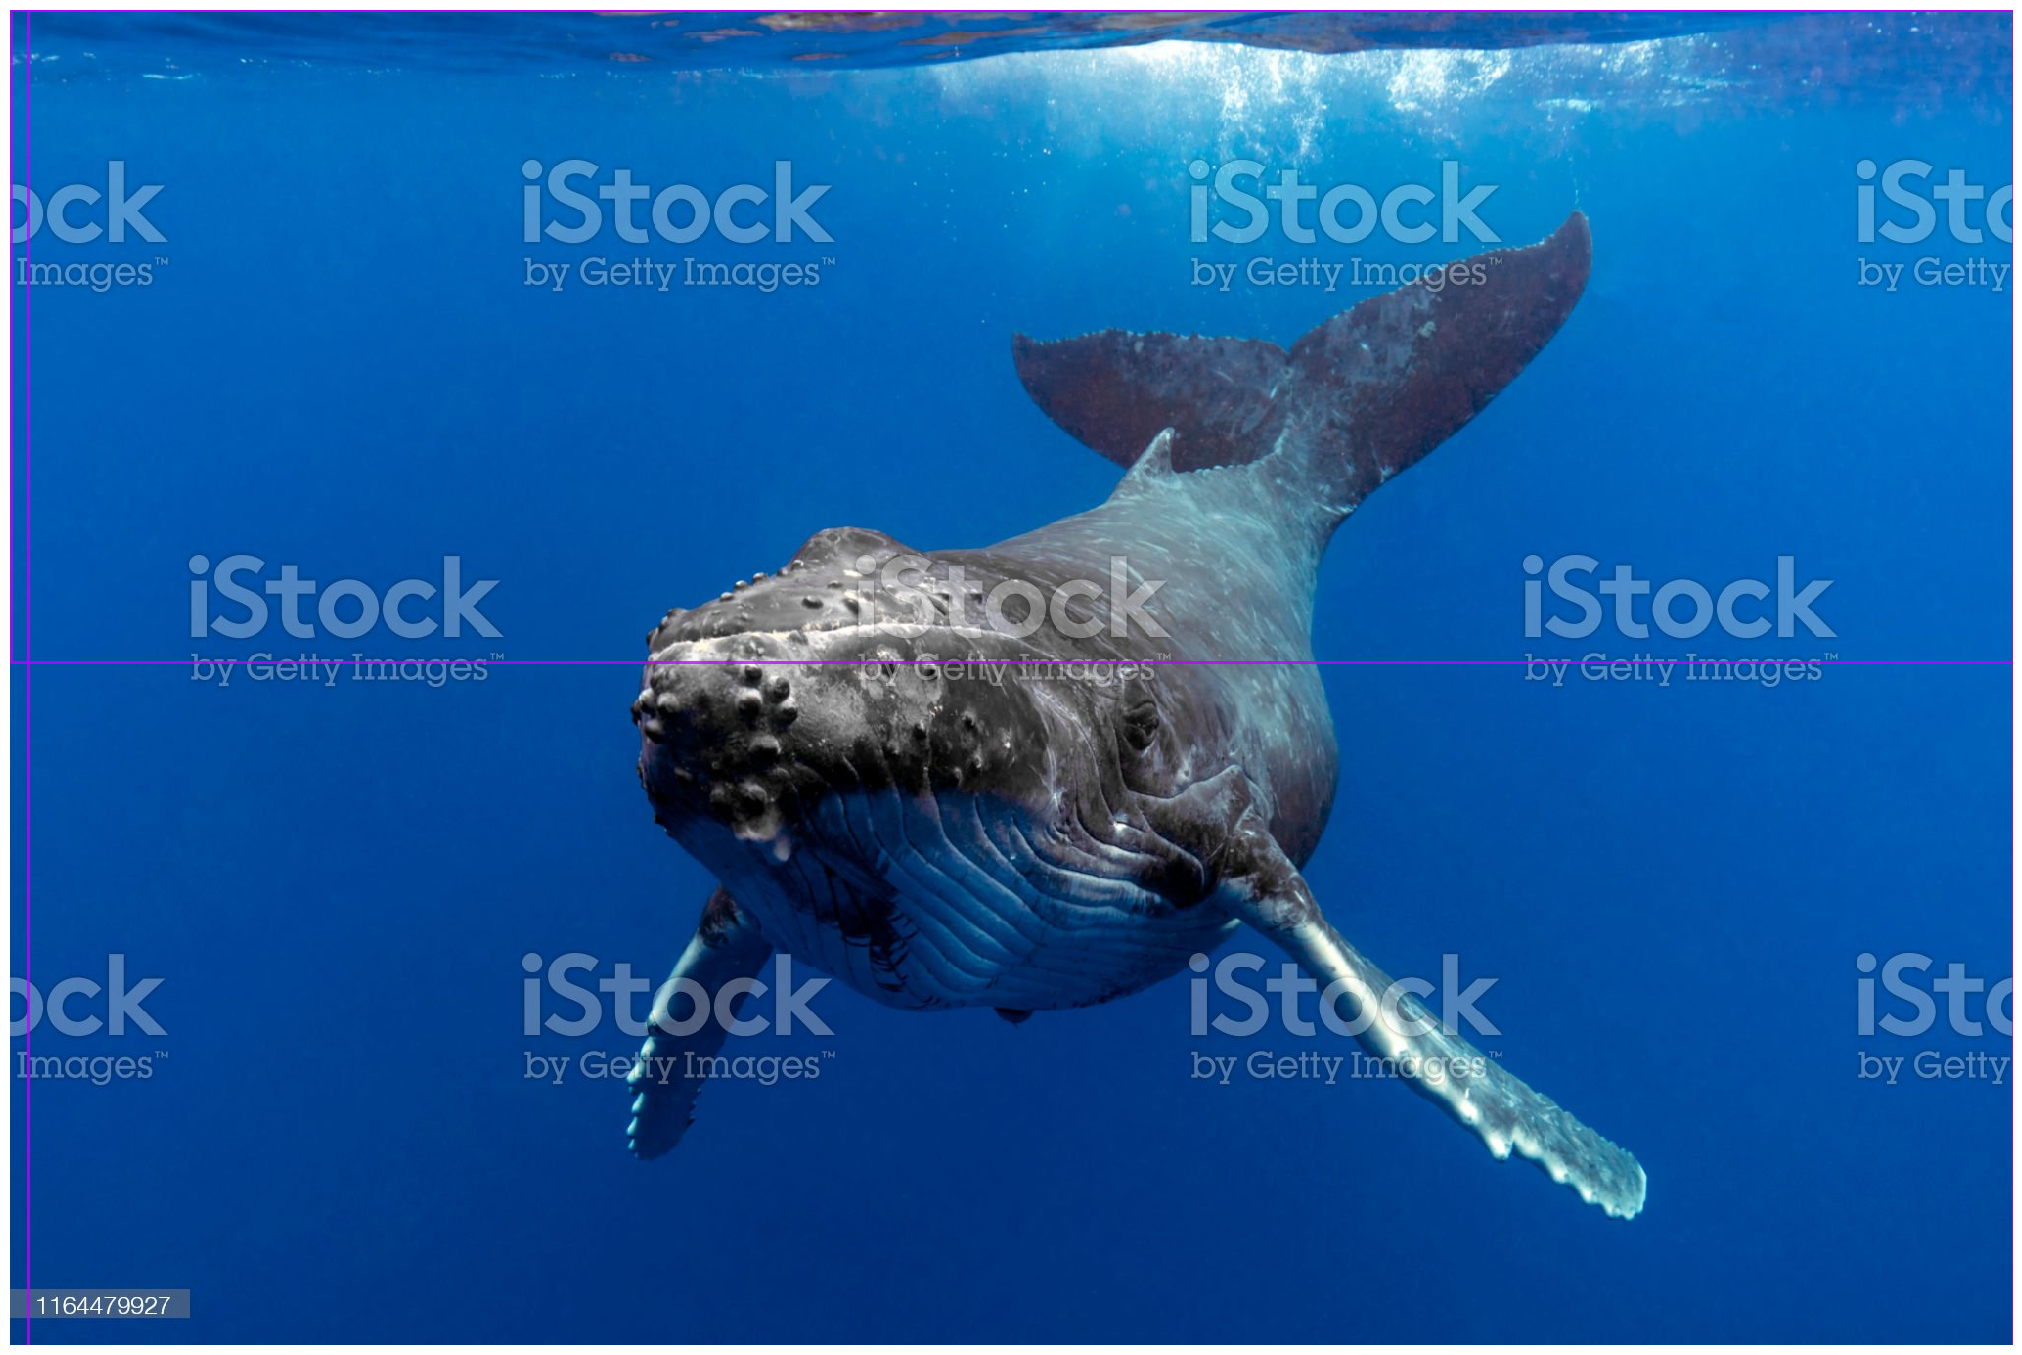

In [ ]:
# Predicting new data
url = 'https://media.istockphoto.com/id/1164479927/photo/close-up-of-a-humpback-whale-calf-in-blue-water.jpg?s=2048x2048&w=is&k=20&c=rAesDsj_7JTcSo9UXA8dE-H1fiCfJ7JQAsn8tXLAk-o='
# 'https://s.hdnux.com/photos/01/26/45/71/22699598/4/1200x0.jpg'
best_model.predict( url,  conf=0.51).show()

In [ ]:
# Saving the predicted image and gathering the details required
from collections import Counter

pred = best_model.predict( url,  conf=0.51)
result = list(pred)[0]

class_names = list(result.class_names)

counter = Counter(list(result.prediction.labels.astype("int")))
output = list(counter.items())
output = list(map(lambda x: (class_names[x[0]],x[1]),output))

# saving the predicted image
pred.save(output_folder="/content/output")

print(output)

[2023-08-13 13:40:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


[('beluga_whale', 2)]


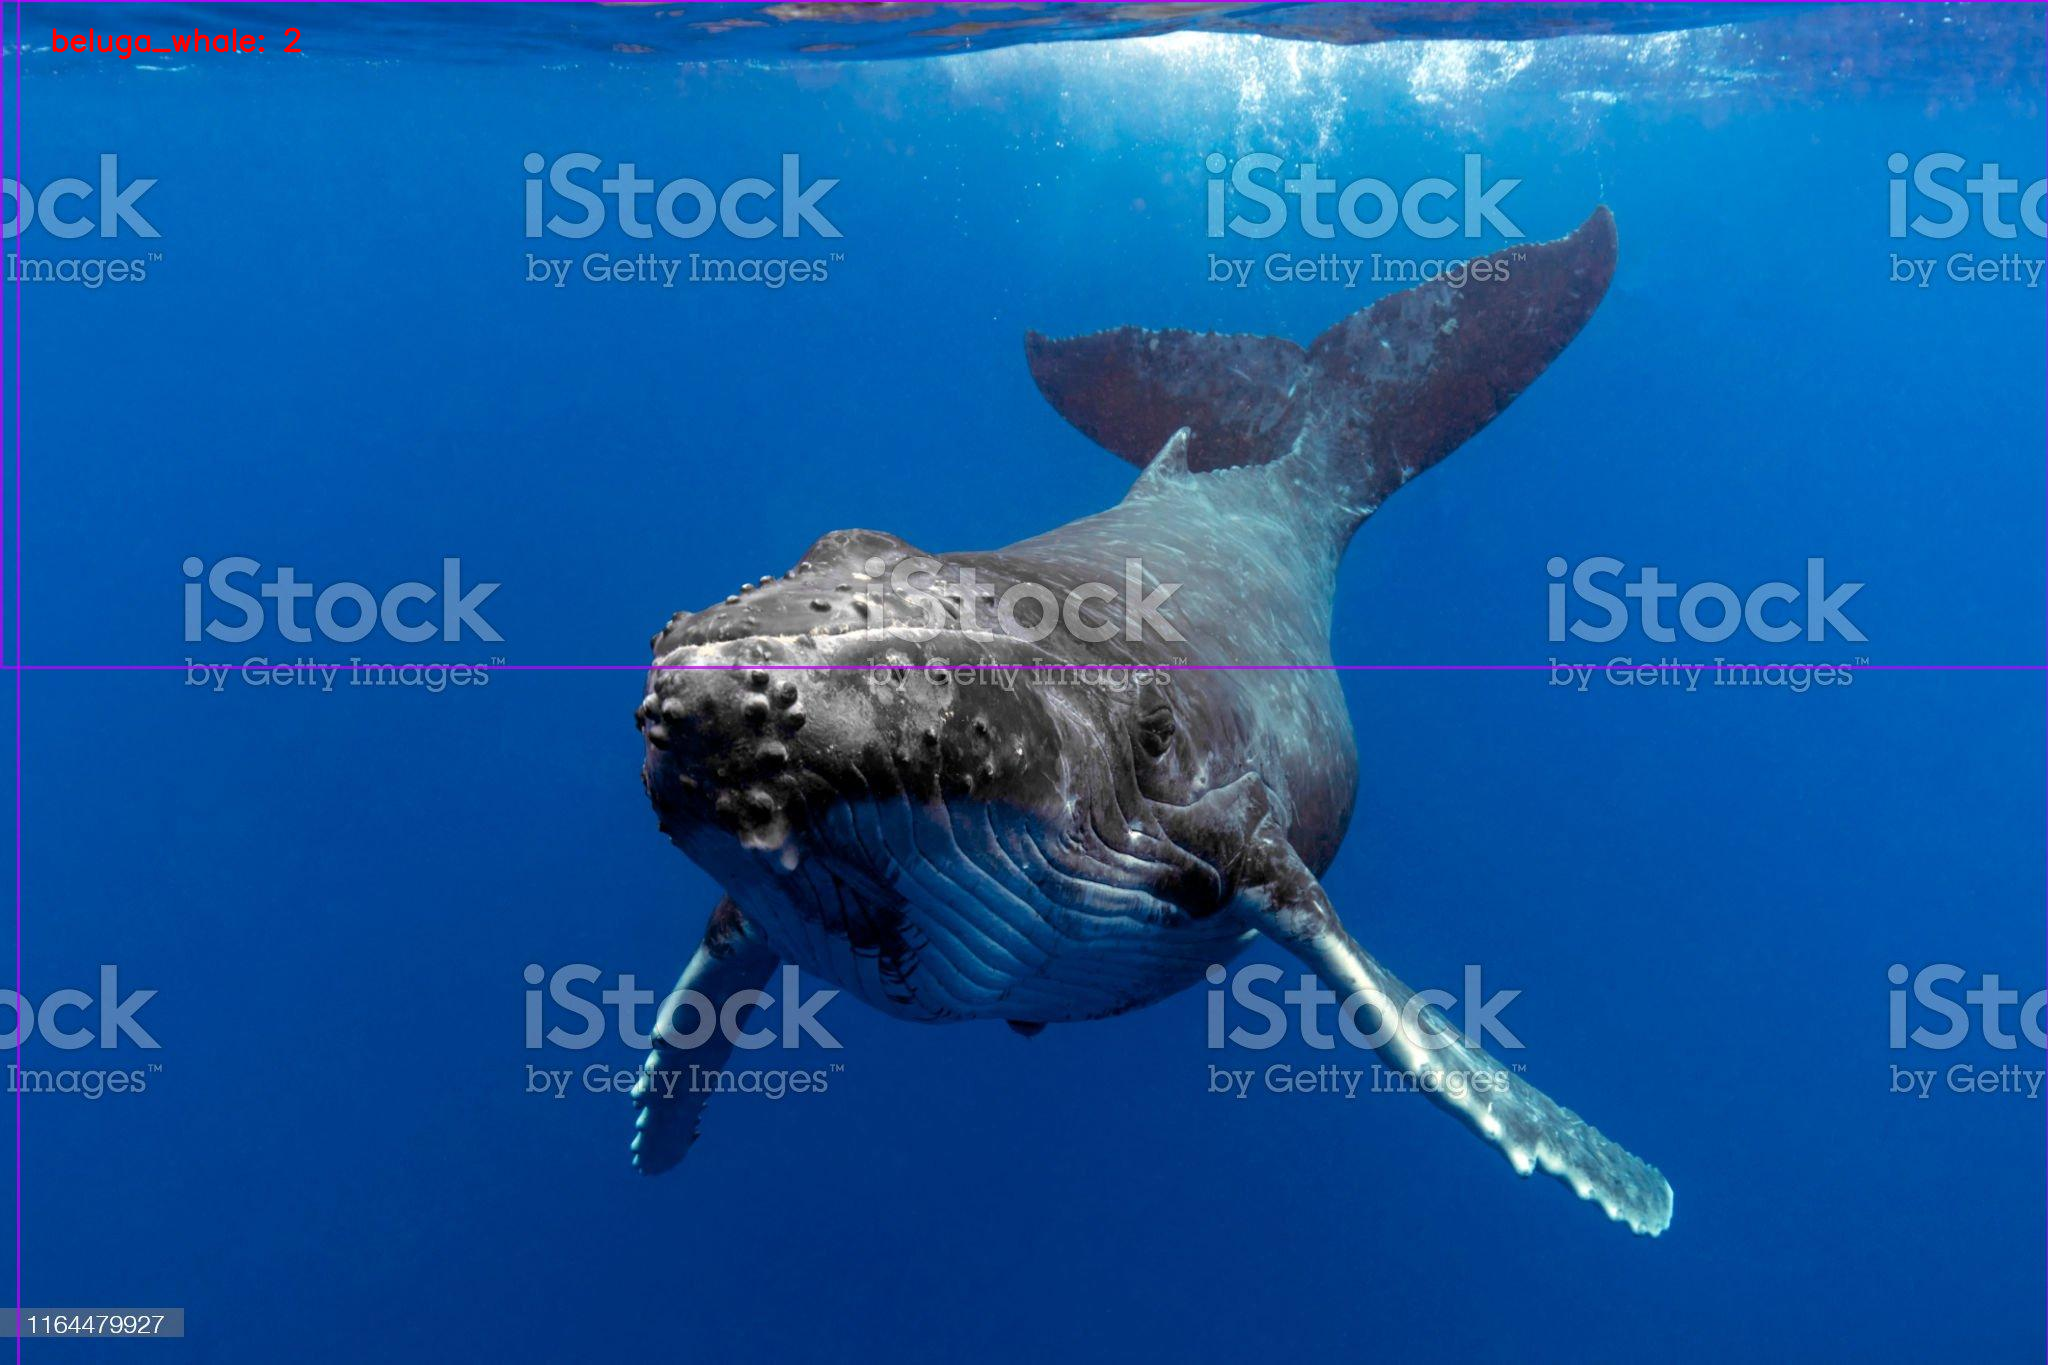

In [ ]:
# To get the number of objects in each class diplayed in the image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from google.colab.patches import cv2_imshow


# path
path = r'/content/output/pred_0.jpg'

# Reading an image in default mode
image = cv2.imread(path)

# Window name in which image is displayed
# window_name = 'Image'

# font
font = cv2.FONT_HERSHEY_SIMPLEX

# org
org = (50, 50)

# fontScale
fontScale = 1

# Blue color in BGR
color = (0,0,255)

# Line thickness of 2 px
thickness = 2

for i in range(len(output)):
  # Using cv2.putText() method
  org = (50, 50*i+50)
  image = cv2.putText(image, str(output[i][0]) + ': '+ str(output[i][1]), org, font, fontScale, color, thickness, cv2.LINE_AA)

# Displaying the image
cv2_imshow(image)